In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

For completeness, the code includes also the plot that shows the relation between weight and error for every stump.

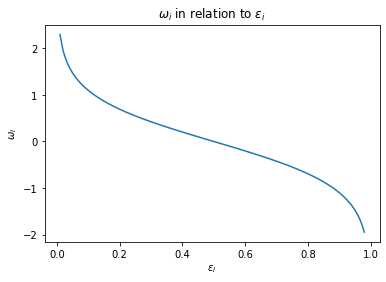

In [2]:
eps = np.arange(0.01,0.99,0.01)
w = 1/2*np.log((1-eps)/eps)
plt.title('$ω_i$ in relation to $ε_i$')
plt.ylabel('$ω_i$')
plt.xlabel('$ε_i$')
plt.plot(eps,w)

plt.savefig("we.jpg",dpi=300)
plt.show()

In [3]:
dataset = pd.read_csv('Datasets/forest-cover-type.csv')
dataset.shape

(15120, 56)

In [4]:
dataset.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


We check for missing values:

In [5]:
dataset.isna().sum()

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


The goal of this analysis is to classify trees into the right forest cover type, stored in the variable Cover_Type. We assess that the variable is balanced in the sample.

In [6]:
dataset.groupby('Cover_Type').count().iloc[:, 0:1]

,Id
Cover_Type,
1,2160
2,2160
3,2160
4,2160
5,2160
6,2160
7,2160


We could do it also graphically:

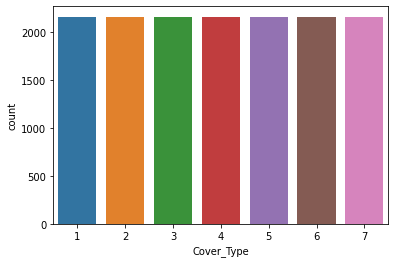

In [7]:
ax = sns.countplot(x="Cover_Type", data=dataset)
fig = ax.get_figure()
fig.savefig("count.png")

We create "spl" possible best threshold for every feature except for the categorical variables (0-1). They have one only possible threshold, 0.5. We will set the parameter "spl" = 100 later on.

In [8]:
def threshold(X_feat,spl):
    #check for categorical features
    if len(set(X_feat)) == 2:
        return np.array([sum(set(X_feat))/2])
    else:
        #spl is the number of splits
        step = (min(X_feat)+max(X_feat))/spl
        thr = np.array([round(((index+1) * step),1) for index in range(spl)])
        return thr

In order to work with y as a boolean (= is or is not of that type), we transform the categorical value into a boolean one for the selected y

In [9]:
def bool_y(y,tp):
    return np.array([-1 if r!=tp else 1 for r in y])

L_i by definition

In [10]:
def L(X_feat,y,thr):
    return np.array([ -1 * y_t if(X_t < thr) else y_t for X_t,y_t in zip(X_feat,y) ])

L_i(t) by definition

In [11]:
def L_t(X_t,y_t,thr):
    h_t = -1 if(X_t < thr) else 1
    return h_t * y_t

Epsilon is by definition the sum of P_i(t) where L_i(t) = -1
If the sum is greater than 0.5, we flip the predictor and keep track of the flip in the variable dir_st

In [12]:
def eps(X_feat,y,thr,P):
   
    h = np.ones(len(y))
    h[X_feat < thr] = -1
            
    dir_st = 1
    min_eps = np.sum(P[h != y])

    #flip eps and change dir
    if min_eps == 1 or min_eps == 0:
        print("Special case " + str(min_eps))
        sys.exit()
    if min_eps > 0.5:
        min_eps = 1 - min_eps
        dir_st = -1       
    
    return min_eps, dir_st

The function below has the sole scope of transforming a tuple of tuples into a plain version of it

In [13]:
def flatten(data):
    return (data[0],data[1],data[2][0],data[2][1])

This function selects the best threshold, given the current P, for the selected feature. Then, among the best splits for each feature, select_feat chooses the one with the smallest error.

In [14]:
def select_feat(X,y,P,thr):

    data = [(i,index,eps(X[:,i],y,thr[i][index],P)) for i in range(X.shape[1]) for index in range(thr[i].shape[0])]
    #returns a tuple (best feature number,best eps,direction)

    return flatten(min(data, key = lambda t: t[2][0]))

Data are then saved into a dictionary while P is updated

In [15]:
def update(best_feat, best_eps_ind,best_eps, direction,P,X_train,y,thr):
    
    w = 1/2 * np.log((1 - best_eps) / best_eps)

    E = np.exp(-1 * w * direction * L(X_train[:,best_feat],y,thr[best_feat][best_eps_ind]))   
    E = np.array([E[t] * P[t] for t in range(X_train.shape[0])])
    E = np.sum(E)
    
    P = np.array([(P[t] * np.exp(-1 * w * direction * L_t(X_train[t,best_feat],y[t],thr[best_feat][best_eps_ind])) / E) for t in range(X_train.shape[0])])
    
    #normalize P
    sum_P = np.sum(P)
    P = P / sum_P    
    
    tree = {
      "feature": best_feat,
      "threshold": best_eps_ind,
      "threshold value": best_eps,
      "dir": direction,
      "w": w  
    }
        
    return P, tree

The whole operation above can be wrapped into the selection of the feature and subsequent update of P and of the forest with the addiction of a new tree.

In [16]:
def add_tree(X_train,y,P,thr,forest):
    best_feat, best_eps_ind,best_eps, direction = select_feat(X_train,y,P,thr)
    P,tree = update(best_feat, best_eps_ind,best_eps, direction,P,X_train,y,thr)

    forest = np.append(forest,tree)
    return forest,P

The operation is repeated for each possible type for T times

In [17]:
def build_forest(T,X_train,y,P,thr):
    forest = np.array([])
    for i in range(T):
        forest,P = add_tree(X_train,y,P,thr,forest)
    return forest

And for each type of the multiclass

In [18]:
def multiforest(T,X_train,y_train,thr):
    global y_set
    
    multiforest = []
    
    for i in y_set:
        P = np.ones(X_train.shape[0])
        P = P / X_train.shape[0]

        this_y = bool_y(y_train,i)
        multiforest.append(build_forest(T,X_train,this_y,P,thr))
    
    return multiforest

The whole code just explained is all we need to build the forest. We now need a way to evaluate its performance, both inside the training set and the test set. The approach in this case is to use a bidimensional matrix and progressively sum the new values where the index is greater or equal to the round number in exam. After that, the zero-one loss is simple: it is equal to one for every record when the classification is different than the real value, i.e. the difference between them is not equal to zero.

In [19]:
def predict(X_k,y_k,thr,multif):
    #predict every entry at each level T
    global T
    
    len_y = len(y_k)
    ind = np.arange(0,T)
    
    #initialize f_multif so that it will be immediately replaced
    f_multif = np.ones((T,len_y)).astype(np.float)*(-5)
    final_pred = np.ones((T,len_y))
    loss = np.zeros((T,len_y))
    
    type_ind = 1
    for i in multif: #types        
        f = np.zeros((T,len_y)).astype(np.float)      
        for j in range(T): #stumps
            thr_num = i[j]['threshold']
            feat = i[j]['feature']
            direction = i[j]['dir']
            w = i[j]['w']
            this_thr = thr[feat][thr_num]
            h = np.array([-1 if X_k_t < this_thr else 1 for X_k_t in X_k[feat]])
                      
            f[ind >= j] = f[ind >= j] + w * h * direction
        
        for j in range(T):
            for jj in range(len_y):
                if f[j][jj] > f_multif[j][jj]:
                    f_multif[j][jj] = f[j][jj]
                    final_pred[j][jj] = type_ind
        type_ind += 1
        
    for j in range(T):
        loss[j][final_pred[j] != y_k] = 1
            
    total_loss = np.array([np.sum([(fp - y_k) != 0])/len_y for fp in final_pred])
    return total_loss

In [20]:
#K = total number of folders, X_len = n of samples, small_k = focus folder
def crossval(small_k):
    global X_len
    global K
    global X
    n = X_len / K
    ind = int(small_k*n)
    S_k_1 = X[0:ind,:]
    y_k_1 = y[0:ind]

    ind = int((small_k+1)*n)
    S_k_2 = X[ind:X_len,:]
    y_k_2 = y[ind:X_len]

    S_k = np.concatenate((S_k_1,S_k_2), axis = 0)

    y_k = np.append(y_k_1,y_k_2)
        
    ind = int((small_k+1)*n)
    D_k = X[int(small_k*n):ind,:]   
    y_D_k = y[int(small_k*n):ind]
        
    thr = np.array([threshold(S_k[:,i],spl) for i in range(S_k.shape[1])],dtype=object)

    #create the forest for each type
    multif = multiforest(T,S_k,y_k,thr)

    #predict
    tr_S_k = np.transpose(S_k)
    tr_D_k = np.transpose(D_k)
    
    train_error = predict(tr_S_k,y_k,thr,multif)
    test_error = predict(tr_D_k,y_D_k,thr,multif)
        
    return train_error, test_error

X, y are initialized

In [21]:
X = dataset.drop(columns=['Id', 'Cover_Type']).values
y = dataset['Cover_Type'].values

y_set = set(y)
X_len = X.shape[0]

As well as the parameters T (number of trees) and K (number of folders) and the thresholds

In [22]:
T = 400
K = 4
#number of possible splits
spl = 100

In [23]:
train_error = []
test_error = []


for i in range(K):
    train_error.append([])
    test_error.append([])
    
for i in range(K):
    tr_error, ts_error = crossval(i)
    train_error[i] = np.append(train_error[i],tr_error)
    test_error[i] = np.append(test_error[i],ts_error)

train_error = np.transpose(train_error)
test_error = np.transpose(test_error)

In [24]:
av_train_error = [np.mean(train_error[i]) for i in range(T)]
std_train_error = [np.std(train_error[i]) for i in range(T)]
av_test_error = [np.mean(test_error[i]) for i in range(T)]
std_test_error = [np.std(test_error[i]) for i in range(T)]

#plot
step = 40
T_ar = np.arange(T)

train_column = [str(np.round(av_train_error[st],5))+"±"+str(np.round(std_train_error[st],5)) for st in T_ar[step-1::step]]
test_column = [str(np.round(av_test_error[st],5))+"±"+str(np.round(std_test_error[st],5)) for st in T_ar[step-1::step]]

d = {'Training error': train_column, 'Test error': test_column}
error_df = pd.DataFrame(data=d,index=T_ar[step-1::step]+1)

error_df

,Training error,Test error
40,0.27782±0.00466,0.32804±0.04186
80,0.26422±0.0059,0.31567±0.03008
120,0.25714±0.00436,0.31144±0.02636
160,0.2506±0.00479,0.31197±0.02816
200,0.24658±0.00628,0.30787±0.02775
240,0.24427±0.00602,0.30979±0.02968
280,0.24224±0.00527,0.30886±0.02879
320,0.24094±0.00513,0.30675±0.02745
360,0.23785±0.00513,0.30734±0.02854
400,0.23618±0.00495,0.30681±0.02779


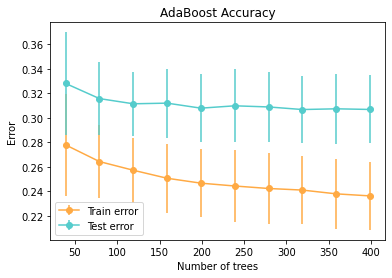

In [25]:
plt.title('AdaBoost Accuracy')
plt.errorbar(T_ar[step-1::step],av_train_error[step-1::step],std_test_error[step-1::step],color='#fa4',label="Train error",marker='o')

plt.errorbar(T_ar[step-1::step],av_test_error[step-1::step],std_test_error[step-1::step],color='#5cc',label="Test error",marker='o')

plt.ylabel('Error')
plt.xlabel('Number of trees')

plt.legend(loc='lower left')

plt.savefig("accuracy.jpg",dpi=300)
plt.show()